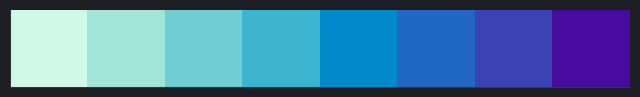

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib.colors import ListedColormap

IS_DARK = False
heatmap_cmap = sns.color_palette('dark:#730aff', as_cmap=True) if IS_DARK else 'Purples'

if IS_DARK:
    heatmap_cmap = ListedColormap([
        '#0f051d', '#170f2c', '#1e1b3c','#25264b', '#2a345c', '#2e416d', '#31507e', '#33608e', '#336f9d', '#317fab', '#2f91b9','#2ba2c5', '#28b4d0', '#28c5da', '#2dd7e2', '#38e9e9'])
else:
    heatmap_cmap = ListedColormap([
        '#d0fae7', '#baf0df', '#a1e5d9', '#88dad5', '#70ced2', '#56c2d0',
       '#3db5cf', '#23a7ce', '#0598cd', '#0089cb', '#0d79c8', '#2168c4',
       '#2f55be', '#3a42b5', '#422cab', '#470c9e'])

sns.palplot(heatmap_cmap(np.linspace(0, 1, 8)))
theme, cs = rp.mpl_setup(IS_DARK)

In [3]:
from pyxtal import Group
from baysic.utils import to_sorted_pretty_string, to_pretty_name, full_symbols

In [4]:
# nums = list(range(1, 41))
# nums.remove(10)
# from pathlib import Path

# for num in nums:
#     path = Path('logs') / f'{num}.feather'
#     if path.exists():
#         df = pd.read_feather(path)
#         df.to_parquet(f'logs/{num}.parquet')

In [5]:
import dask.dataframe as dd
from baysic.utils import to_pretty_name

from dask.distributed import Client
client = Client()

df = dd.read_parquet('logs/')

df = df.reset_index(drop=True)
df['group_symbol'] = df['group_symbol'].str.replace(r'_(\d)', lambda m: chr(int(f'208{m.groups()[0]}', base=16)), regex=True)
df['group_symbol'] = df['group_symbol'].str.replace(r'-(\d)', '\\1\u0305', regex=True)
df = df.categorize(['lattice_type', 'group_symbol'])

lat_order = 'monoclinic triclinic orthorhombic tetragonal hexagonal cubic'.split(' ')
group_order = to_pretty_name(np.arange(1, 231))

df['lattice_type'].cat.set_categories(lat_order, ordered=True)
df['group_symbol'].cat.set_categories(group_order, ordered=True)
df

,comp_ind,e_form,group_num,volume_ratio,lattice_type,wyckoff_letters,total_dof,group_symbol,comp,i
npartitions=32,,,,,,,,,,
,int64,float64,int64,float64,category[known],category[unknown],int64,category[known],category[unknown],int64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [6]:
# import gc
# df1 = pd.read_feather('logs/1_24.feather').reset_index(drop=True)
# df2 = pd.read_feather('logs/28-40.feather').reset_index(drop=True)
# df = pd.concat([df1, df2]).reset_index(drop=True)
# del df1
# del df2
# gc.collect()

# for cat_col in ('wyckoff_letters', 'i', 'total_dof', 'comp_ind', 'comp', 'volume_ratio'):
#     df[cat_col] = pd.Categorical(df[cat_col])

# df['group_symbol'] = pd.Categorical(df['group_symbol'], to_pretty_name(range(1, 231)), ordered=True)
# df['group_num'] = pd.Categorical(df['group_num'], sorted(set(df['group_num'])), ordered=True)


In [7]:
from baysic.utils import json_to_df, load_mp20, df_to_json

mp20 = load_mp20('train')

from pyxtal import Group
lattice_types = pd.Series([Group(g).lattice_type for g in range(1, 231)], index=range(1, 231))
lat_order = df['lattice_type'].cat.categories
mp20['lattice_type'] = pd.Categorical(lattice_types.loc[mp20['sg_number']].values, lat_order, ordered=True)
mp20.head()

,Unnamed: 0,material_id,formation_energy_per_atom,band_gap,pretty_formula,e_above_hull,struct,comp,sg_number,sg_symbol,conv,hall,wyckoffs,crystallographic_orbits,equivalent_atoms,std_mapping_to_primitive,lattice,num_atoms,sg,lattice_type
0,37228,mp-1221227,-1.637460,0.2133,Na3MnCoNiO6,0.043001,"[[-2.13163694 -1.97863317 -0.78933557] Na, [-1...","(Na, Mn, Co, Ni, O)",8,Cm,"[[11.33211764 1.514642 5.35627895] Na, [1....",C -2y,"[a, a, a, a, a, a, a, a, a, a, a, a]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2...",0.603093 -2.968643 0.000000\n0.000000 0.000000...,12,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,monoclinic
1,19480,mp-974729,-0.314759,0.0000,Nd(Al2Cu)4,0.000000,"[[0. 0. 0.] Nd, [7.81740995 6.73412703 1.55353...","(Nd, Al, Cu)",139,I4/mmm,"[[0. 0. 0.] Nd, [4.450648 4.450648 2.599559] N...",-I 4 2,"[a, j, j, i, i, i, i, j, j, f, f, f, f]","[0, 1, 1, 3, 3, 3, 3, 1, 1, 9, 9, 9, 9]","[0, 1, 1, 3, 3, 3, 3, 1, 1, 9, 9, 9, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 0, ...",1.713765 4.489418 -1.984682\n1.713765 4.489418...,13,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,tetragonal
2,29624,mp-1185360,-0.193761,0.0000,LiMnIr2,0.018075,[[5.00000041e-11 5.10035615e+00 0.00000000e+00...,"(Li, Mn, Ir)",225,Fm-3m,"[[0. 2.944692 0. ] Li, [0. 0....",-F 4 2 3,"[b, a, c, c]","[0, 1, 2, 2]","[0, 1, 2, 2]","[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]",1.202165 3.400237 2.082212\n1.202165 3.400237 ...,4,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,cubic
3,38633,mp-1188861,-0.584694,3.8556,LiCSN,0.048847,"[[ 0.96469575 2.34470985 11.12401327] Li, [0....","(Li, C, S, N)",62,Pnma,"[[11.12401327 0.96469575 2.34470985] Li, [4....",-P 2ac 2n,"[c, c, c, c, c, c, c, c, c, c, c, c, c, c, c, c]","[0, 0, 0, 0, 4, 4, 4, 4, 8, 8, 8, 8, 12, 12, 1...","[0, 0, 0, 0, 4, 4, 4, 4, 8, 8, 8, 8, 12, 12, 1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3.858783 0.000000 0.000000\n-0.000000 5.345396...,16,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,orthorhombic
4,10889,mp-677272,-2.474759,0.4707,La2EuS4,0.000000,"[[ 0.03187948 -4.65810216 -3.8370089 ] La, [ 2...","(La, Eu, S)",122,I-42d,"[[6.584643 7.65405048 3.26744475] La, [7.654...",I -4 2bw,"[d, d, d, d, a, a, e, e, e, e, e, e, e, e]","[0, 0, 0, 0, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6]","[0, 0, 0, 0, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3.552553 -6.184474 -2.579065\n-3.606854 6.184...,14,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,tetragonal


In [8]:
from pymatgen.core import Composition
mp20['repeat'] = mp20['std_mapping_to_primitive'].apply(lambda x: len(x) // len(set(x)))
mp20['reduced_formula'] = (mp20['comp'] * mp20['repeat']).apply(lambda c: to_sorted_pretty_string(c.reduced_composition))
mp20 = mp20.set_index('reduced_formula')
df['reduced_formula'] = df['comp'].apply(lambda c: to_sorted_pretty_string(Composition(c).reduced_composition),
meta=('reduced_formula', str)).astype('category').cat.as_known()
# mp20['formula'] = (mp20['comp'] * mp20['repeat']).apply(to_sorted_pretty_string)
# df['formula'] = df['comp'].apply(lambda c: to_sorted_pretty_string(Composition(c)))
# subs = df[df['reduced_formula'].isin(mp20['reduced_formula'])]
# print(len(subs.index) / len(df.index))
df['true_lattice_type'] = df['lattice_type']

def reassign(df):
    for num in set(df['i']):
        subs = df[df['i'] == num]
        mp20_subs = mp20[np.arange(len(mp20.index)) % 250 == (num - 1)]
        counts = mp20_subs.index.value_counts()
        counts = counts[counts != 1]
        subs = subs[~subs['reduced_formula'].isin(counts.index)]
        lat_types = mp20_subs.loc[subs['reduced_formula'], 'lattice_type']

        df.loc[subs.index, 'true_lattice_type'] = lat_types.values
        df.loc[subs.index, 'mp_id'] = mp20_subs.loc[subs['reduced_formula'], 'material_id'].values

    return df

df = df.map_partitions(reassign)

# the MVC data is just too unreliable for space group information: perhaps it can be used downstream in some other way
# subset to just the data we have ground truth for
df = df.loc[df['mp_id'].str.startswith('mp')]
df['mp_id'] = df['mp_id'].astype('category')
df

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


,comp_ind,e_form,group_num,volume_ratio,lattice_type,wyckoff_letters,total_dof,group_symbol,comp,i,reduced_formula,true_lattice_type,mp_id
npartitions=32,,,,,,,,,,,,,
,int64,float64,int64,float64,category[known],category[unknown],int64,category[known],category[unknown],int64,category[known],category[known],category[unknown]
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [9]:
# df.memory_usage(deep=True).compute() / 1e6

In [14]:
true_lats = df.groupby('comp', observed=False).first()['true_lattice_type']
quants_group = df[['comp', 'lattice_type', 'e_form']].groupby(['comp', 'lattice_type'], observed=False)
quants = quants_group.aggregate(['min', 'mean'])
quants.columns = quants.columns.droplevel()
quants['e_form'] = quants['min'] + (quants['mean'] - quants['min']) * 0.1
quants = quants.pivot_table(values='e_form', index='comp', columns='lattice_type')

KeyError: 'lattice_type'

In [ ]:
confusion = pd.crosstab(
    true_lats,
    quants.idxmin(axis=1),
    normalize='index'
)
confusion = confusion.loc[order, order]
acc = np.diag(confusion.values).sum() / 6
sns.heatmap(confusion, annot=True, fmt='.0%', cmap=heatmap_cmap)

plt.xticks(rotation=40, ha='right')
plt.ylabel('True')
plt.xlabel('Pred')
plt.title(f'{acc:.2%}')

In [ ]:
quants_order = pd.DataFrame(np.argsort(np.argsort(quants)), index=quants.index, columns=quants.columns)
quants_order.head()

In [ ]:
sns.displot(x=np.array([quants_order.loc[true_lats.index[i], true_lats.values[i]] if true_lats.values[i] is not np.nan else np.nan for i in range(len(true_lats.index))]),
col=true_lats, kind='hist', discrete=True, col_order=df['lattice_type'].cat.categories)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def ridge_plot(
    df: pd.DataFrame,
    group_var: str,
    num_var: str,
    order_by = lambda x: np.nanquantile(x, 0.1),
    height: int = 10,
    subplot_height: float = 0.8
):
    if order_by is not None:
        order = df[[group_var, num_var]].groupby(group_var, observed=True).agg(order_by)[num_var].sort_values().index
        palette = 'rho_solara'

    else:
        order = pd.unique(df[group_var])
        palette = 'rho_iso_spectra'

    hspace = -0.5
    num_rows = int(height / ((1 + hspace) * subplot_height))
    num_cols = int(np.ceil(len(order) / num_rows))
    pad_order = np.concatenate([order.values, [np.nan for _ in range(num_rows * num_cols - len(order))]], dtype=object)
    pad_order = pad_order.reshape(num_rows, num_cols)
    order_i = 0
    for j in range(num_cols):
        for i in range(num_rows):
            if not pd.isnull(pad_order[i, j]):
                pad_order[i, j] = order[order_i]
                order_i += 1
    col_order = pad_order.flatten()
    col_order = col_order[~pd.isnull(col_order)]
    hue_order = df[[group_var, num_var]].groupby(group_var, observed=True).agg(order_by)[num_var].sort_values().index

    g = sns.FacetGrid(
        df, col=group_var, hue=group_var, aspect=8, height=subplot_height, col_wrap=num_cols,
        palette=palette, col_order=col_order, hue_order=hue_order, sharey=False)

    # Draw the densities in a few steps
    kde_params = dict(bw_adjust=0.5)
    g.map(sns.kdeplot, num_var, clip_on=False,
        fill=True, alpha=1, linewidth=1.5, edgecolor=plt.rcParams['figure.facecolor'], **kde_params)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.set_facecolor((0, 0, 0, 0))
        ax.set_ylabel(label, color=color, ha="right", rotation=0, y=0, va='bottom')

    g.map(label, "lattice_type")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=hspace)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.set_xlabels(num_var)
    g.despine(bottom=True, left=True)

    return g

mp_id = "mp-8432"
comp = mp20.set_index('material_id').loc[mp_id, 'pretty_formula']
true = '{} ({})'.format(*mp20.set_index('material_id').loc[mp_id, ['sg_symbol', 'lattice_type']])
g = ridge_plot(df.query('mp_id == @mp_id and e_form < 0'), 'group_symbol', 'e_form', height=8)
g.figure.suptitle(f'{comp} ({true})')

In [ ]:
df.query('mp_id == @mp_id').sort_values('e_form')

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
subs = df.query('mp_id == @mp_id and e_form < 0 and group_num == 176')
letters = sorted(set(sum([s.split('_') for s in subs['wyckoff_letters']], [])))
cols = []
for l in letters:
    cols.append(f'has_{l}')
    subs[f'has_{l}'] = subs['wyckoff_letters'].str.contains(l)

display(subs.sort_values('e_form'))
sns.displot(subs, x='e_form', hue='has_d', fill=False, element='poly', row='has_b', col='has_c', height=2, aspect=2)

In [ ]:
g = ridge_plot(df.iloc[:2_000_000].query('group_num == 194 and e_form < 0'), 'comp', 'e_form', height=8)

In [ ]:
dist = df[['comp', 'group_symbol', 'e_form']].groupby(['comp', 'group_symbol'], observed=False).quantile(np.linspace(0.01, 0.8, 17)).unstack().unstack()
# dist = ((dist.T - dist.median(axis=1).values) / (dist.quantile([0.75, 0.25], axis=1).T.diff(axis=1).iloc[:, -1])).T
dist = ((dist.T - dist.mean(axis=1).values) / (dist.std(axis=1).values)).T
dist

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import sklearn.metrics as metrics

In [ ]:
dist = dist.dropna(axis=1, thresh=int(len(dist.index) * 0.2))
print(dist.shape)
X = KNNImputer(weights='distance').fit_transform(dist[~pd.isnull(true_lats)])
y = true_lats[~pd.isnull(true_lats)]

y_group = np.ones_like(true_lats) * np.nan
y_group[~pd.isnull(true_lats)] = mp20.set_index('material_id').loc[df.groupby('comp').first()['mp_id'].dropna().values, 'sg_symbol']
y_group = y_group[~pd.isnull(y_group)]

In [ ]:
auto_df = pd.DataFrame(X, dist.index[~pd.isnull(true_lats)], dist.columns)
auto_df.columns = auto_df.columns.droplevel(0)
auto_df.columns = [' '.join(map(str, col)).strip() for col in auto_df.columns.values]
auto_df['target'] = y
auto_df['target_group'] = y_group
display(auto_df)
auto_df.to_feather('system_prediction.feather')

In [ ]:
def visualize_model(mod, y, cv=10):
    mod.fit(X, y)
    preds = cross_val_predict(mod, X, y, cv=StratifiedKFold(cv))

    use_order = len(set(y)) == len(order)
    conf_mat = confusion_matrix(y, preds, labels=order if use_order else None, normalize='true').astype(float)
    sns.heatmap(conf_mat, annot=len(set(y)) < 12, xticklabels=order if use_order else 'auto', yticklabels=order if use_order else 'auto', cmap='rocket', fmt='.0%')
    plt.title('\n'.join([
        'MCC: {:.3f}'.format(matthews_corrcoef(y, preds)),
        'Accuracy: {:.3f}'.format(metrics.accuracy_score(y, preds))
    ]))
    return preds

In [ ]:
mod = LogisticRegression(multi_class='multinomial', penalty='l2', max_iter=100, solver='lbfgs', C=5e-3)

preds = visualize_model(mod, y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

mod2 = RandomForestClassifier(n_estimators=300)
preds2 = visualize_model(mod2, y)

In [ ]:
mod3 = RandomForestClassifier(n_estimators=100)
visualize_model(mod3, y_group)

In [ ]:
from sklearn.neural_network import MLPClassifier

mod4 = MLPClassifier(hidden_layer_sizes=(250, 250, 250), activation='tanh', alpha=5e-2)
preds4 = visualize_model(mod4, y)